In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model

from hysteresis.base import BaseHysteresis
from hysteresis.hybrid import ExactHybridGP
from hysteresis.visualization import plot_hysterion_density

def ground_truth_function(m):
    return torch.sin(m)

def load():
    toy_model = torch.load('toy_magnet_decay.pt')

    train_h = toy_model.history_h.reshape(-1, 1)
    train_m = toy_model.history_m.reshape(-1, 1)

    train_y = ground_truth_function(train_m) + torch.randn(train_m.shape) * 0.0
    return train_h, train_m, train_y, toy_model

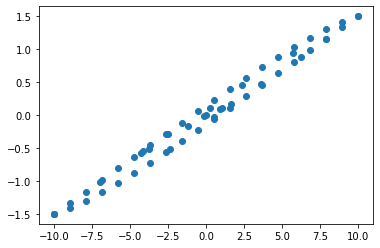

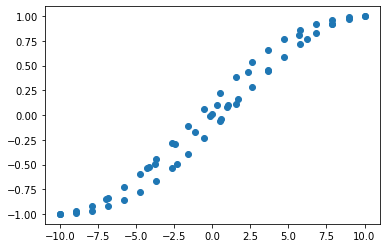

In [2]:
train_x, train_m, train_y, toy_model = load()
plt.figure()
plt.plot(train_x, train_m, 'o')

plt.figure()
plt.plot(train_x, train_y,'o')


In [3]:

H = BaseHysteresis(train_x.flatten(), polynomial_degree=3, mesh_scale=0.5)
likelihood = GaussianLikelihood()
model = ExactHybridGP(train_x, train_y.flatten().clone(), H, likelihood)

mll = ExactMarginalLogLikelihood(likelihood, model)
res = fit_gpytorch_model(mll)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

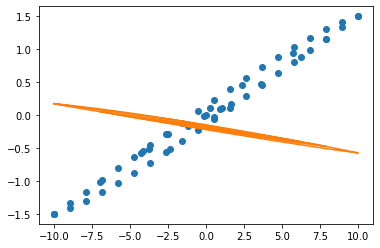

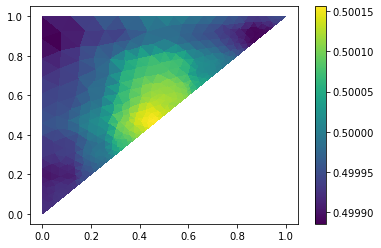

In [4]:
# prediction of hysteresis
model.hysteresis_models[0].regression()
plt.figure()
plt.plot(train_x, train_m, 'o')
plt.plot(
    train_x,
    model.hysteresis_models[0](train_x.flatten(), return_real=True).detach()
)

plot_hysterion_density(model.hysteresis_models[0])

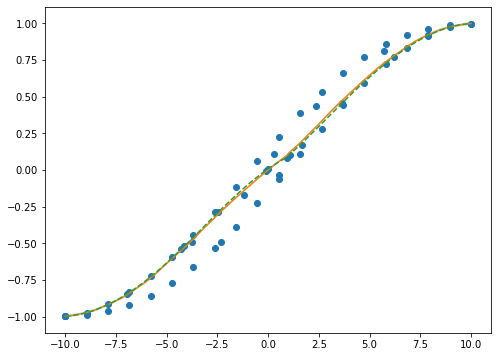

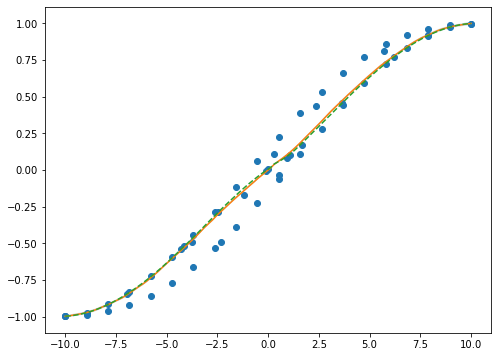

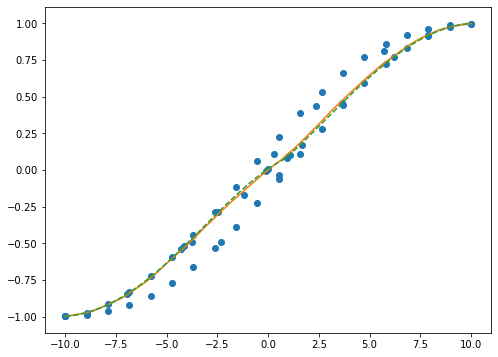

In [5]:
# predict with joint model
flds = torch.tensor([1.0, 0.25, 0.75])
for ele in flds:
    toy_model.apply_field(ele)
    toy_model.next()

    model.apply_fields(ele.reshape(1,1))
    model.next()

    test_x = torch.linspace(*H.valid_domain, 100)
    with torch.no_grad():
        post = model(test_x.double().reshape(-1, 1, 1))
        mean = post.mean
        l, u = post.confidence_region()

    m_gt = toy_model(test_x.double().reshape(-1,1,1))
    y_gt = ground_truth_function(m_gt).squeeze().detach()

    plt.figure(figsize=(8,6))
    plt.plot(train_x, train_y, 'o')
    plt.plot(test_x, mean)
    plt.fill_between(test_x, l, u, alpha=0.25)
    plt.plot(test_x, y_gt,'--')
